# Набор данных

**Оценка стоимости  и типа трансмиссии по данным продаж автомобилей на вторичном рынке Молдавии**

Набор данных представляет собой статистику параметров автомобилей на вторичном рынке в Молдавии. 

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный параметр. 

Среди указанных параметров приведены целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди параметров есть целевой для задачи классификации - тип трансмиссии. 
 
 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий параметр).

## Import библиотек

In [ ]:
import pandas as pd
from google.colab import files 

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Загрузка данных на Google Drive

In [ ]:
uploaded = files.upload()

Saving cars_moldova_cat_num.csv to cars_moldova_cat_num.csv


## Считываем файл в DataFrame



метод .read_csv(path,delimiter) 

In [ ]:
df = pd.read_csv('/content/cars_moldova_cat_num.csv', delimiter = ',')
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),km_year
0,40,92,2011,4,195000.0,1800.0,2,1,7750.0,17727.272727
1,32,62,2014,11,135000.0,1500.0,0,0,8550.0,16875.000000
2,32,71,2012,11,110000.0,1500.0,0,0,6550.0,11000.000000
3,28,23,2006,11,200000.0,1600.0,3,0,4100.0,12500.000000
4,23,124,2000,5,300000.0,2200.0,0,0,3490.0,13636.363636
...,...,...,...,...,...,...,...,...,...,...
32069,42,88,2016,10,88000.0,1800.0,4,1,11500.0,14666.666667
32070,19,53,2002,3,225000.0,1800.0,3,0,4400.0,11250.000000
32071,6,77,2015,11,89000.0,1500.0,0,0,7000.0,12714.285714
32072,22,10,2006,1,370000.0,2000.0,0,0,4000.0,23125.000000


In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission'] 
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']


# Классификация Методом к-Ближайших Соседей


In [ ]:
from sklearn.neighbors import  KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1

In [ ]:
X = df[num_columns].values 
y = df["Transmission"].values 
features_names = df[num_columns].columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 

In [ ]:
#@title Параметры к-Ближайших Соседей{ run: "auto" }
#@markdown ### количество соседей
k = 9 #@param {type:"slider", min:1, max:15, step:1}
#@markdown ### тип весов
weights = 'distance' #@param [ 'uniform', 'distance']{type:"string"}

kNN = KNeighborsClassifier(n_neighbors=k, weights=weights )


kNN.fit(X_train, y_train)

y_predict=kNN.predict(X_test)

scoring = {'ACC': 'accuracy',
           'F1': 'f1',
           'Precision': 'precision',
           'Recall': 'recall'}
           
scores = cross_validate(kNN, X_train, y_train,
                      scoring=scoring, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=42))


print('Результаты Кросс-валидации')
DF_cv_kNN = pd.DataFrame(scores)
display(DF_cv_kNN)
print('\n')
print(DF_cv_kNN.mean()[2:])

print (classification_report(y_test, y_predict, target_names=['Manual','Automatic']))

Результаты Кросс-валидации


,fit_time,score_time,test_ACC,test_F1,test_Precision,test_Recall
0,0.013513,0.047468,0.806279,0.781627,0.810094,0.755092
1,0.012755,0.044958,0.820490,0.795119,0.835470,0.758487
2,0.012502,0.049319,0.810022,0.785840,0.814680,0.758972
3,0.014084,0.053024,0.810022,0.787016,0.811117,0.764306
4,0.012631,0.049517,0.805791,0.780020,0.812401,0.750121




test_ACC          0.810521
test_F1           0.785924
test_Precision    0.816752
test_Recall       0.757396
dtype: float64
              precision    recall  f1-score   support

      Manual       0.82      0.87      0.84      5253
   Automatic       0.83      0.77      0.80      4370

    accuracy                           0.82      9623
   macro avg       0.82      0.82      0.82      9623
weighted avg       0.82      0.82      0.82      9623



## Поиск Лучших Гиперпараметров по Сетке Параметров

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {'n_neighbors':np.arange(1,30,4), 
              'weights':['uniform', 'distance']}

kNN_search = GridSearchCV(estimator = KNeighborsClassifier(),verbose = 3,
                          param_grid=parameters ,cv=StratifiedKFold(n_splits=5))

kNN_search.fit(X_train, y_train)

kNNbest=kNN_search.best_estimator_

kNNbest.fit(X_train, y_train);

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ....n_neighbors=1, weights=uniform;, score=0.778 total time=   0.1s
[CV 2/5] END ....n_neighbors=1, weights=uniform;, score=0.780 total time=   0.1s
[CV 3/5] END ....n_neighbors=1, weights=uniform;, score=0.776 total time=   0.2s
[CV 4/5] END ....n_neighbors=1, weights=uniform;, score=0.765 total time=   0.1s
[CV 5/5] END ....n_neighbors=1, weights=uniform;, score=0.770 total time=   0.1s
[CV 1/5] END ...n_neighbors=1, weights=distance;, score=0.778 total time=   0.0s
[CV 2/5] END ...n_neighbors=1, weights=distance;, score=0.780 total time=   0.0s
[CV 3/5] END ...n_neighbors=1, weights=distance;, score=0.776 total time=   0.0s
[CV 4/5] END ...n_neighbors=1, weights=distance;, score=0.765 total time=   0.0s
[CV 5/5] END ...n_neighbors=1, weights=distance;, score=0.770 total time=   0.0s
[CV 1/5] END ....n_neighbors=5, weights=uniform;, score=0.807 total time=   0.1s
[CV 2/5] END ....n_neighbors=5, weights=uniform;

In [ ]:
kNN_search.best_estimator_

KNeighborsClassifier(n_neighbors=25, weights='distance')

In [ ]:
scoring = {'ACC': 'accuracy',
           'F1': 'f1',
           'Precision': 'precision',
           'Recall': 'recall'}

scores = cross_validate(kNNbest, X_train, y_train,
                      scoring=scoring, cv=StratifiedKFold(n_splits=5, shuffle = True, random_state=42))


print('Результаты Кросс-валидации')
DF_cv_best_kNN = pd.DataFrame(scores)
display(DF_cv_best_kNN)
print('\n')
print(DF_cv_best_kNN.mean()[2:])

Результаты Кросс-валидации


,fit_time,score_time,test_ACC,test_F1,test_Precision,test_Recall
0,0.012963,0.075139,0.813627,0.786969,0.828066,0.749758
1,0.012635,0.072495,0.829176,0.803283,0.852477,0.759457
2,0.012434,0.078766,0.820713,0.794170,0.839913,0.753152
3,0.016728,0.089633,0.820490,0.795328,0.834755,0.759457
4,0.012949,0.077919,0.816258,0.790130,0.830481,0.753518




test_ACC          0.820053
test_F1           0.793976
test_Precision    0.837139
test_Recall       0.755068
dtype: float64


In [ ]:
y_predict=kNNbest.predict(X_test)

print (classification_report(y_test, y_predict, target_names=['Manual','Automatic']))

              precision    recall  f1-score   support

      Manual       0.82      0.89      0.85      5253
   Automatic       0.85      0.76      0.80      4370

    accuracy                           0.83      9623
   macro avg       0.83      0.83      0.83      9623
weighted avg       0.83      0.83      0.83      9623



**Рассмотрим результаты перебора**

In [ ]:
DF_class=pd.DataFrame(kNN_search.cv_results_)
DF_class

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013005,0.000476,0.124197,0.011306,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.778000,0.779955,0.775501,0.764811,0.770156,0.773685,0.005522,15
1,0.013168,0.000565,0.019027,0.000806,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.778000,0.779955,0.775501,0.764811,0.770156,0.773685,0.005522,15
2,0.013776,0.001307,0.155809,0.031911,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.806725,0.810022,0.805345,0.798886,0.809354,0.806067,0.003974,13
3,0.013917,0.001161,0.033442,0.001523,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.804943,0.806682,0.802895,0.791982,0.808463,0.802993,0.005807,14
4,0.014695,0.002836,0.150753,0.013746,9,uniform,"{'n_neighbors': 9, 'weights': 'uniform'}",0.813627,0.813808,0.815590,0.804677,0.815145,0.812570,0.004017,11
5,0.013694,0.000732,0.042485,0.001565,9,distance,"{'n_neighbors': 9, 'weights': 'distance'}",0.817413,0.815813,0.811359,0.804677,0.816704,0.813193,0.004751,10
6,0.013607,0.000636,0.176860,0.041867,13,uniform,"{'n_neighbors': 13, 'weights': 'uniform'}",0.812959,0.813808,0.811136,0.809577,0.812472,0.811991,0.001485,12
7,0.018696,0.003071,0.075449,0.006644,13,distance,"{'n_neighbors': 13, 'weights': 'distance'}",0.819862,0.820935,0.813808,0.809131,0.818486,0.816445,0.004392,5
8,0.020462,0.003275,0.246729,0.010551,17,uniform,"{'n_neighbors': 17, 'weights': 'uniform'}",0.812737,0.818931,0.812918,0.811581,0.812695,0.813772,0.002622,9
9,0.015244,0.003510,0.057855,0.001762,17,distance,"{'n_neighbors': 17, 'weights': 'distance'}",0.819417,0.824053,0.815367,0.812695,0.820267,0.818360,0.003955,4


**Уберем лишние столбцы и добавим раскраску**

In [ ]:
DF = DF_class[['param_n_neighbors','param_weights',
               'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("seagreen", as_cmap=True)
hl = DF.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

,param_n_neighbors,param_weights,mean_test_score,std_test_score,rank_test_score
13,25,distance,0.821478,0.004150,1
15,29,distance,0.820721,0.004082,2
11,21,distance,0.820587,0.004125,3
9,17,distance,0.818360,0.003955,4
7,13,distance,0.816445,0.004392,5
10,21,uniform,0.816222,0.003141,6
14,29,uniform,0.815821,0.003037,7
12,25,uniform,0.815554,0.003772,8
8,17,uniform,0.813772,0.002622,9
5,9,distance,0.813193,0.004751,10


# Регрессия Методом к-Ближайших Соседей

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

**Считываем данные, разбиваем на тестовую и тренировочную, нормализуем**

In [ ]:
df_num = df[num_columns].copy()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

**Применение Регрессии**

In [ ]:
#@title Параметры к-Ближайших Соседей{ run: "auto" }
#@markdown ### количество соседей
k = 9 #@param {type:"slider", min:1, max:15, step:1}
#@markdown ### тип весов
weights = 'distance' #@param [ 'uniform', 'distance']{type:"string"}

kNN = KNeighborsRegressor(n_neighbors=k, weights=weights )


kNN.fit(X_train, y_train)

y_predict=kNN.predict(X_test)

scoring = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}
           
scores = cross_validate(kNN, X_train, y_train,
                      scoring=scoring, cv=ShuffleSplit(n_splits=5, random_state=42))


print('Результаты Кросс-валидации')
DF_cv_kNN = pd.DataFrame(scores)
display(DF_cv_kNN)
print('\n')
print(DF_cv_kNN.mean()[2:])

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test,y_predict))
print('RMSE: %.1f' % mse(y_test,y_predict,squared=False))

print('R2 : %.4f' %  r2_score(y_test,y_predict))

Результаты Кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,0.013575,0.013959,0.714708,-2.420856e+07,-2647.078214,-83000.000000
1,0.012336,0.013407,0.741050,-2.641547e+07,-2757.935806,-83000.000000
2,0.012182,0.013828,0.660909,-2.970565e+07,-2808.876658,-96609.321027
3,0.012133,0.013444,0.732683,-2.562256e+07,-2718.391243,-83938.872815
4,0.012084,0.013376,0.774945,-2.051695e+07,-2697.777325,-47189.849057




test_R2      7.248589e-01
test_-MSE   -2.529384e+07
test_-MAE   -2.726012e+03
test_Max    -7.874761e+04
dtype: float64
Ошибка на тестовых данных
MSE: 26449566.0
RMSE: 5142.9
R2 : 0.7294


## Поиск Лучших Гиперпараметров с Помощью Рандомизированного Поиска

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

In [ ]:
parameters = {'n_neighbors':stats.randint(1,50), 'weights':['uniform', 'distance']}
n_iter_search = 20
kNN_search = RandomizedSearchCV(estimator = KNeighborsRegressor(),verbose = 3,
                          param_distributions=parameters ,cv=ShuffleSplit(n_splits=5, random_state=42),n_iter = n_iter_search)

kNN_search.fit(X_train, y_train)

kNNbest=kNN_search.best_estimator_

kNNbest.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.740 total time=   0.0s
[CV 2/5] END ....n_neighbors=4, weights=uniform;, score=0.769 total time=   0.0s
[CV 3/5] END ....n_neighbors=4, weights=uniform;, score=0.698 total time=   0.0s
[CV 4/5] END ....n_neighbors=4, weights=uniform;, score=0.724 total time=   0.0s
[CV 5/5] END ....n_neighbors=4, weights=uniform;, score=0.744 total time=   0.0s
[CV 1/5] END ..n_neighbors=31, weights=distance;, score=0.720 total time=   0.0s
[CV 2/5] END ..n_neighbors=31, weights=distance;, score=0.755 total time=   0.0s
[CV 3/5] END ..n_neighbors=31, weights=distance;, score=0.670 total time=   0.0s
[CV 4/5] END ..n_neighbors=31, weights=distance;, score=0.747 total time=   0.0s
[CV 5/5] END ..n_neighbors=31, weights=distance;, score=0.781 total time=   0.0s
[CV 1/5] END ..n_neighbors=32, weights=distance;, score=0.721 total time=   0.0s
[CV 2/5] END ..n_neighbors=32, weights=distance

In [ ]:
kNN_search.best_estimator_

KNeighborsRegressor(n_neighbors=12)

In [ ]:
y_predict=kNNbest.predict(X_test)

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test,y_predict))
print('RMSE: %.1f' % mse(y_test,y_predict,squared=False))

print('R2 : %.4f' %  r2_score(y_test,y_predict))

Ошибка на тестовых данных
MSE: 22936498.8
RMSE: 4789.2
R2 : 0.7653


**Рассмотрим результаты перебора**

In [ ]:
DF_reg=pd.DataFrame(kNN_search.cv_results_)
DF = DF_reg[['param_n_neighbors','param_weights',
             'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("purple", as_cmap=True)
hl = DF.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

,param_n_neighbors,param_weights,mean_test_score,std_test_score,rank_test_score
3,12,uniform,0.771275,0.018599,1
14,12,uniform,0.771275,0.018599,1
4,25,uniform,0.763805,0.020443,3
7,33,uniform,0.760850,0.021313,4
8,8,uniform,0.760091,0.022422,5
18,40,uniform,0.757230,0.020788,6
6,41,uniform,0.756677,0.020862,7
15,42,uniform,0.756285,0.020453,8
12,5,uniform,0.742278,0.025506,9
2,32,distance,0.735191,0.037965,10


In [ ]:
def print_stem(y, label, marker):
    markerline, stemlines, baseline = plt.stem(y, markerfmt=marker,label = label,use_line_collection = True, )
    markerline.set_markerfacecolor('none')

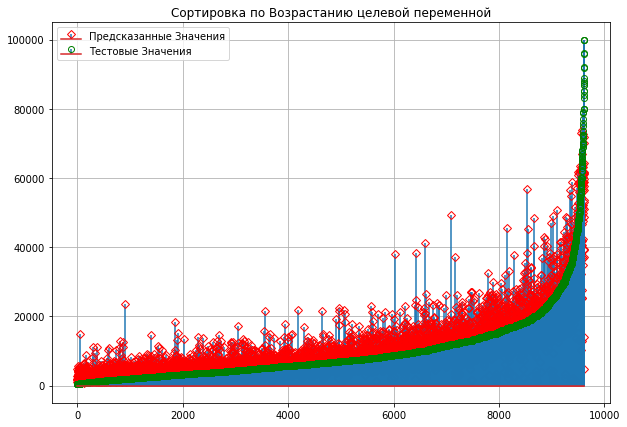

In [ ]:
fig=plt.figure(figsize=(10, 7))
sorted = np.argsort(y_test)
print_stem(y_predict[sorted], 'Предсказанные Значения', 'rD')
print_stem(y_test[sorted], 'Тестовые Значения', 'go')

plt.grid()
plt.title('Сортировка по Возрастанию целевой переменной')
plt.legend();

# Neighborhood Components Analysis

In [ ]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis

**Считываем данные, разбиваем на тестовую и тренировочную, нормализуем**

In [ ]:
X = df[num_columns].values 
y = df["Transmission"].values 

features_names = df[num_columns].columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

Применяем Neighborhood Components Analysis

На тестовых данных, потому что может не хватить памяти

In [ ]:
nca = NeighborhoodComponentsAnalysis(n_components=2)
nca.fit(X_test,y_test)
X_nca = nca.transform(X_test)

Трансформируем оставшиеся данные

In [ ]:
X_nca_train = nca.transform(X_train)

**Визуализируем новое пространство**

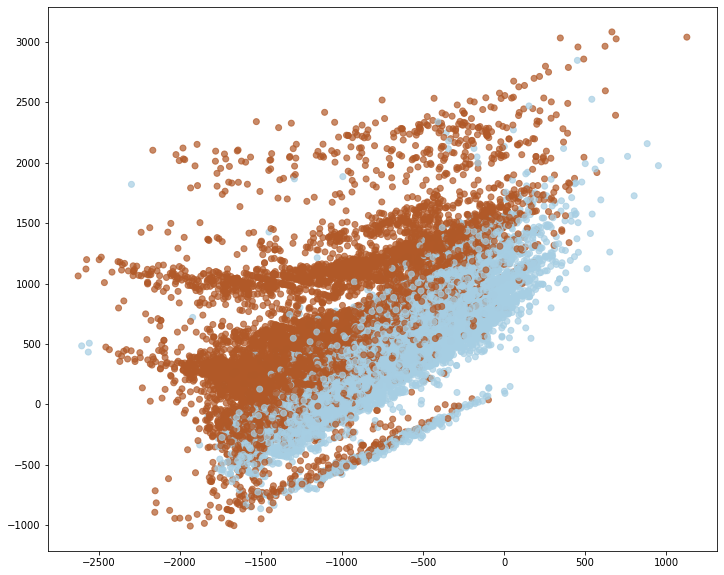

In [ ]:
plt.figure(figsize=(12,10))
plt.scatter(X_nca_train[:,0],X_nca_train[:,1], c =y_train, alpha = 0.7, cmap ='Paired' ,); 

Визуализация "весов" преобразования

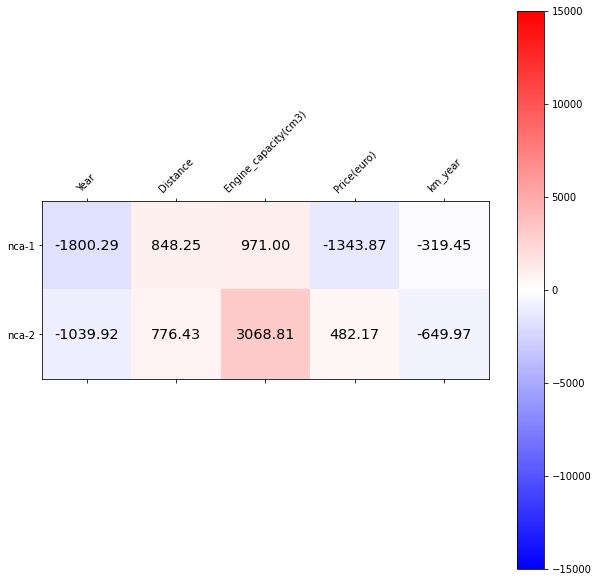

In [ ]:
fig=plt.figure(figsize=(10,10))
W = nca.components_
nca_names = ['nca-'+str(x+1) for x in range(W.shape[0])]
plt.matshow(W.astype(float),cmap='bwr',vmin=-15000,vmax=15000, fignum=1)
for (i, j), z in np.ndenumerate(W):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', color = 'k', fontsize = 'x-large')
plt.xticks(np.arange(0, W.shape[1]), features_names,rotation = 45)
plt.yticks(np.arange(0, W.shape[0]),nca_names)
plt.colorbar();

Сравниваем Классификацию на обычных данных и на преобразованных

In [ ]:
kNN = KNeighborsClassifier(n_neighbors=19,weights='distance' )

kNN.fit(X_nca_train, y_train)

scoring = {'ACC': 'accuracy',
           'F1': 'f1',
           'Precision': 'precision',
           'Recall': 'recall'}

scores = cross_validate(kNN, X_nca_train, y_train,scoring=scoring, cv=StratifiedKFold(n_splits=5))

y_predict=kNN.predict(X_nca)


print('Cross-Validation error')


DF_nca=pd.DataFrame(scores)
DF_nca.columns = [name+'_nca' for name in DF_nca.columns]

DF_temp=pd.concat([DF_cv_best_kNN,DF_nca],axis=1)


display(DF_temp)
print('\n')
print(DF_temp.mean())
print('\n')


Cross-Validation error


,fit_time,score_time,test_ACC,test_F1,test_Precision,test_Recall,fit_time_nca,score_time_nca,test_ACC_nca,test_F1_nca,test_Precision_nca,test_Recall_nca
0,0.012963,0.075139,0.813627,0.786969,0.828066,0.749758,0.053571,0.163345,0.813474,0.787028,0.826412,0.751227
1,0.012635,0.072495,0.829176,0.803283,0.852477,0.759457,0.014461,0.065990,0.809977,0.782471,0.823800,0.745091
2,0.012434,0.078766,0.820713,0.794170,0.839913,0.753152,0.016725,0.047184,0.804088,0.775372,0.817763,0.737160
3,0.016728,0.089633,0.820490,0.795328,0.834755,0.759457,0.013922,0.087044,0.810151,0.785435,0.815447,0.757553
4,0.012949,0.077919,0.816258,0.790130,0.830481,0.753518,0.024334,0.216535,0.812576,0.786081,0.824896,0.750755




fit_time              0.013542
score_time            0.078791
test_ACC              0.820053
test_F1               0.793976
test_Precision        0.837139
test_Recall           0.755068
fit_time_nca          0.024603
score_time_nca        0.116020
test_ACC_nca          0.810053
test_F1_nca           0.783277
test_Precision_nca    0.821664
test_Recall_nca       0.748357
dtype: float64




# tSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
#@title Параметры tSNE {run: "auto" }
n_iter = 350 #@param {type:"slider", min:250, max:500, step:25}
perplexity = 50 #@param {type:"slider", min:5, max:50, step:5}

tsne = TSNE(n_components=2, verbose=1, 
            perplexity=perplexity, n_iter=n_iter, )

tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 32074 samples in 0.037s...


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 32074 samples in 1.547s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32074
[t-SNE] Computed conditional probabilities for sample 2000 / 32074
[t-SNE] Computed conditional probabilities for sample 3000 / 32074
[t-SNE] Computed conditional probabilities for sample 4000 / 32074
[t-SNE] Computed conditional probabilities for sample 5000 / 32074
[t-SNE] Computed conditional probabilities for sample 6000 / 32074
[t-SNE] Computed conditional probabilities for sample 7000 / 32074
[t-SNE] Computed conditional probabilities for sample 8000 / 32074
[t-SNE] Computed conditional probabilities for sample 9000 / 32074
[t-SNE] Computed conditional probabilities for sample 10000 / 32074
[t-SNE] Computed conditional probabilities for sample 11000 / 32074
[t-SNE] Computed conditional probabilities for sample 12000 / 32074
[t-SNE] Computed conditional probabilities for sample 13000 / 32074
[t-SNE] Computed conditional probabilities for sample 14000 / 32074

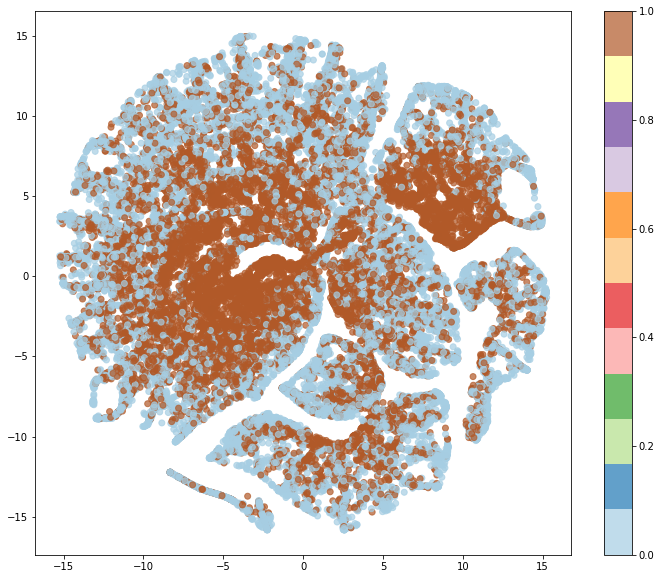

In [ ]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], c =df.Transmission.values, alpha = 0.7, cmap ='Paired' ,)
plt.colorbar();

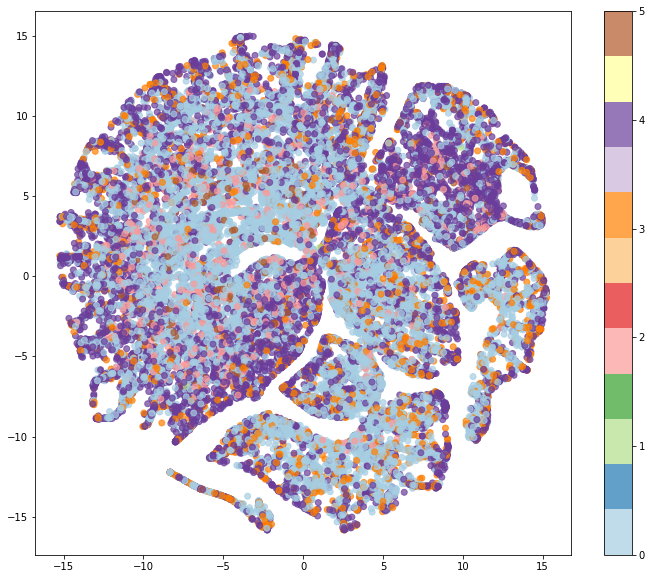

In [ ]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], c =df.Fuel_type.values, alpha = 0.7, cmap ='Paired' ,)
plt.colorbar();

# Контрольные вопросы